# DECaLS Sky Brightness

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import speclite

import astropy.io.fits
import astropy.table
import astropy.time
import astropy.coordinates
import astropy.units as u 

import specsim.atmosphere
import specsim.simulator

from desiutil.plots import plot_sky_binned, plot_sky_circles, init_sky

#### Load the data

In [4]:
hdus = astropy.io.fits.open('data/decalsobs-zpt-dr3-allv2.fits')

def make_table():
    t = astropy.table.Table()
    for name in ('DATE', 'AIRMASS', 'RA', 'DEC', 'FILTER', 'SKYBR', 'MOONSEP', 'MOONPHASE', 'MOONUP', 'SUNALT', 
                 'SUNSEP', 'TRANSP', 'EXPTIME', 'ZD', 'SEEING', 'SKYSIG', 'DEPTH'):
        values = hdus[1].data[name].reshape(-1)
        t[name] = astropy.table.Column(values)
    t['MOONFRAC'] = t['MOONPHASE']
    t['MOONPHASE'] = np.arccos(2 * t['MOONFRAC'] - 1.) / np.pi
    return t

t = make_table()

In [5]:
# Only keep values with airmass != 0.0
keep_airmass = t['AIRMASS'] != 0.0
t = t[keep_airmass]

#### Get moon (alt, az) positions

In [6]:
time = astropy.time.Time(t['DATE'], format='jd')
location = astropy.coordinates.EarthLocation.from_geodetic(
    lat='-30d10m10.78s', lon='-70d48m23.49s', height=2241.4*u.m)

moon_position = astropy.coordinates.get_moon(time, location)
moon_ra = moon_position.ra.value
moon_dec = moon_position.dec.value
moon_position_altaz = moon_position.transform_to(astropy.coordinates.AltAz(obstime=time, location=location))
moon_alt = moon_position_altaz.alt.value
moon_az = moon_position_altaz.az.value

#### Make cuts on transparency and moon altitude

Transparency is the fraction of the expected light that reaches us.

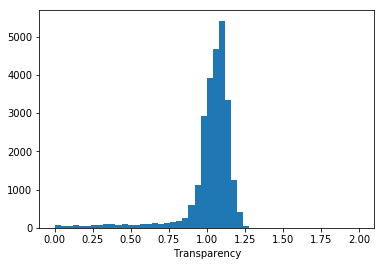

In [8]:
plt.hist(t['TRANSP'], bins=50, range=(0, 2))
plt.xlabel('Transparency')
plt.show()

In [11]:
sel_g = (t['FILTER'] == 'g') & (moon_alt > 10.) & (t['TRANSP'] > .75) & (t['TRANSP'] < 1.3)
sel_r = (t['FILTER'] == 'r') & (moon_alt > 10.) & (t['TRANSP'] > .75) & (t['TRANSP'] < 1.3)
sel_z = (t['FILTER'] == 'z') & (moon_alt > 10.) & (t['TRANSP'] > .75) & (t['TRANSP'] < 1.3)

t_g = t[sel_g]
t_r = t[sel_r]
t_z = t[sel_z]